In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

In [3]:
data_dir = "./word2vec_data/words/"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [4]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [5]:
words = fetch_words_data()

In [6]:
len(words)

17005207

In [7]:
from collections import Counter

In [ ]:
Counter.most_common

In [9]:
def create_counts(vocab_size=50000):
    vocab = [] + Counter(words).most_common(vocab_size)
    #If u are not concerned about the other information in tuple use _
    vocab = np.array([word for word, _ in vocab])
    #Create a dictionary
    dictionary = {word:code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word, 0) for word in words])
    
    return data, vocab

** Each word(in data) is assinged some sort of number(in vocabulary) **

In [10]:
data, vocabulary = create_counts()

** In gensm the following method of creating the batches is automatically taken care by it **

In [11]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

** Constants **

In [12]:
batch_size = 128 
embedding_size = 150

#how many words to be considered to the left & to the right
skip_window = 1

#how many times to reuse the input to generate a label 
num_skips = 2

In [14]:
#Random set of words to evaluate similarity on 
valid_size = 16 

In [15]:
valid_window = 100
valid_examples = np.random.choice(valid_window,valid_size,replace=False)


In [16]:
num_sampled = 64 

In [17]:
learning_rate = 0.01

In [18]:
vocabulary_size = 50000

In [19]:
#Reset deafult graph
tf.reset_default_graph()

In [20]:
#Placeholders
train_ip = tf.placeholder(tf.int32, shape=[None])

In [21]:
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [22]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [23]:
#Embeddings 
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)

In [24]:
embeddings = tf.Variable(init_embeds)

In [25]:
embed = tf.nn.embedding_lookup(embeddings, train_ip)

** Loss Fucntions **

In [27]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/np.sqrt(embedding_size)))

In [28]:
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [29]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)


In [31]:
trainer = optimizer.minimize(loss)

In [32]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [33]:
# Add variable initializer.
init = tf.global_variables_initializer()

In [34]:
data_index = 0 

** Session ** 

In [35]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [38]:
num_steps = 5000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_ip : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  287.311096191
Average loss at step  1000 :  8695.95162463
Average loss at step  2000 :  22702.4077485
Average loss at step  3000 :  30120.0963406
Average loss at step  4000 :  36179.1768576


In [39]:
from sklearn.manifold import TSNE

** Basically the manifold converts a 3D image into a 2D plane **

In [40]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [41]:
plot_only = 500

In [42]:
low_dimension_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [43]:
labels = [vocabulary[i] for i in range(plot_only)]

In [44]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [45]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

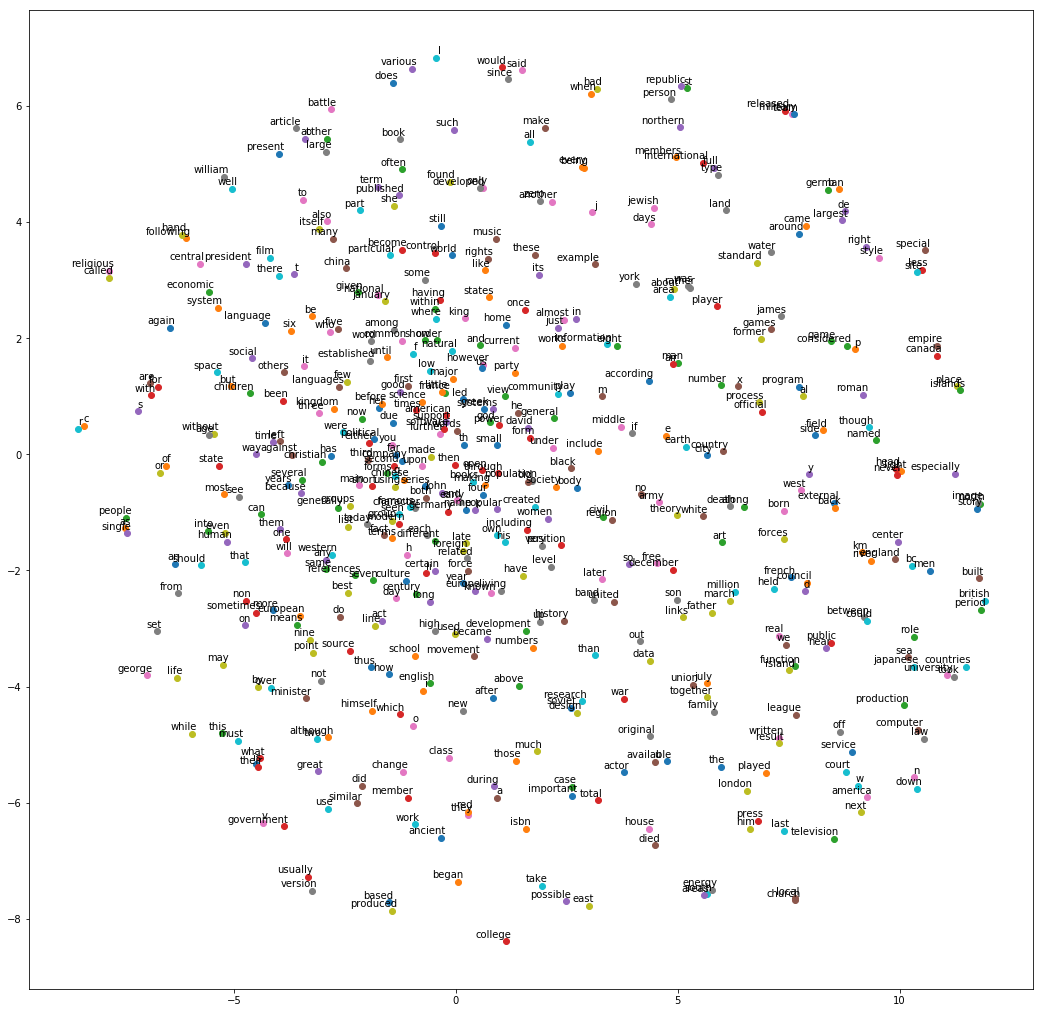

In [47]:
plot_with_labels(low_dimension_embed, labels)

** Low Dimensional Display **

(-10, 10)

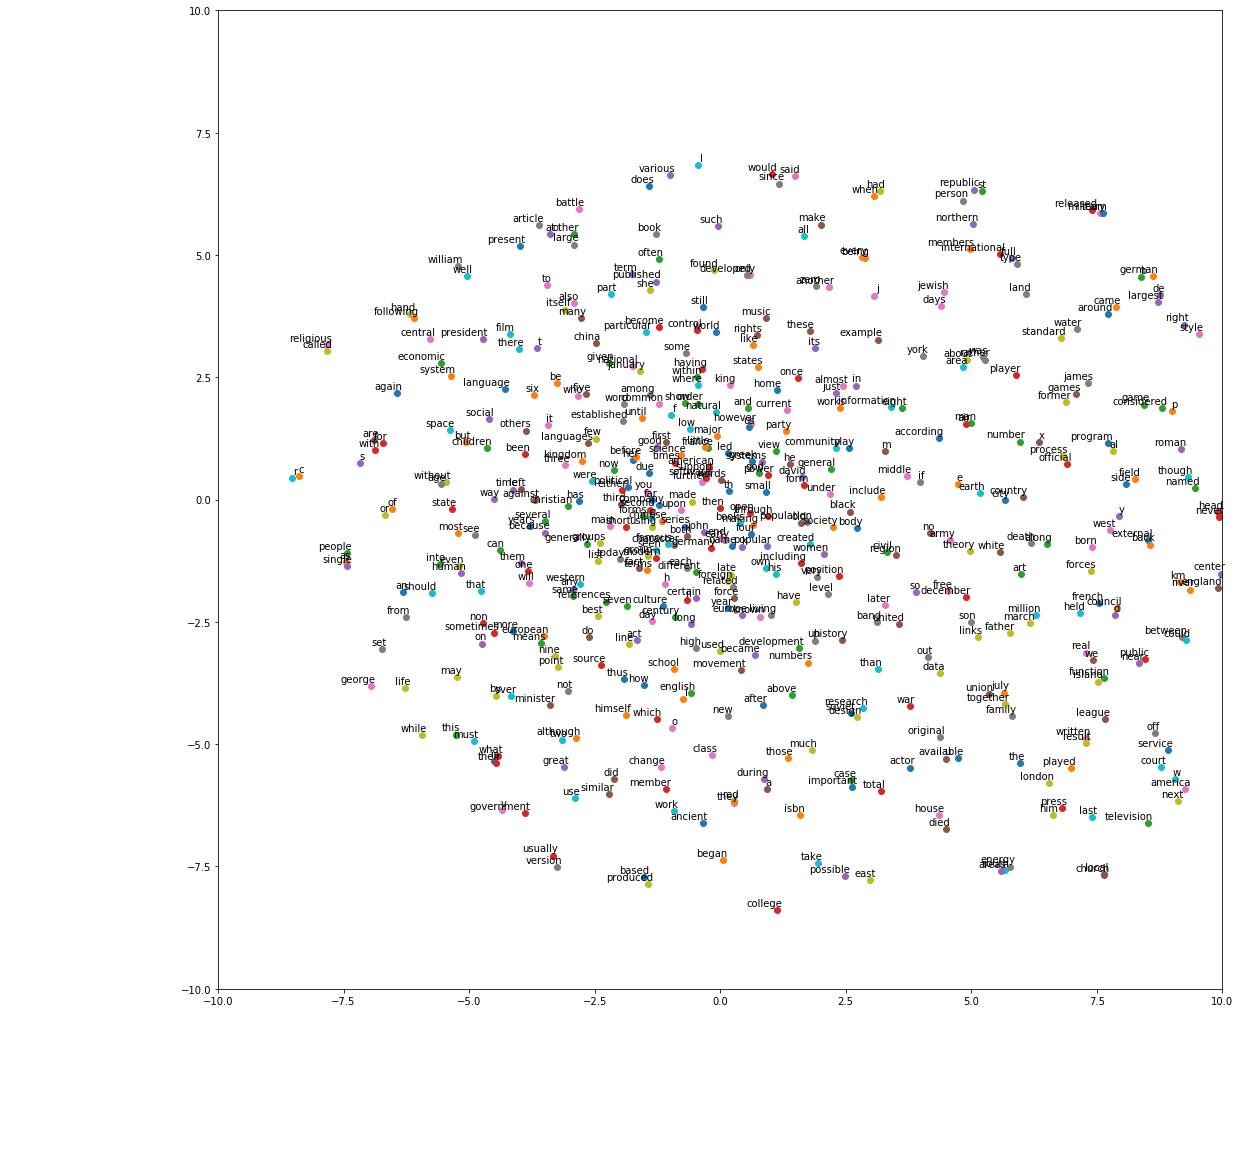

In [49]:
plot_with_labels(low_dimension_embed, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)